## What is Trend?
- a persistent, long-term change in the mean of the series
- window : 이동 평균을 계산할 때 사용되는 기간
    - 윈도우 크기가 365일 -> 해당 날 포함하여 이전 364일 동안의 평균

In [3]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
tunnel = pd.read_csv("./csv/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

### Moving Average Plots


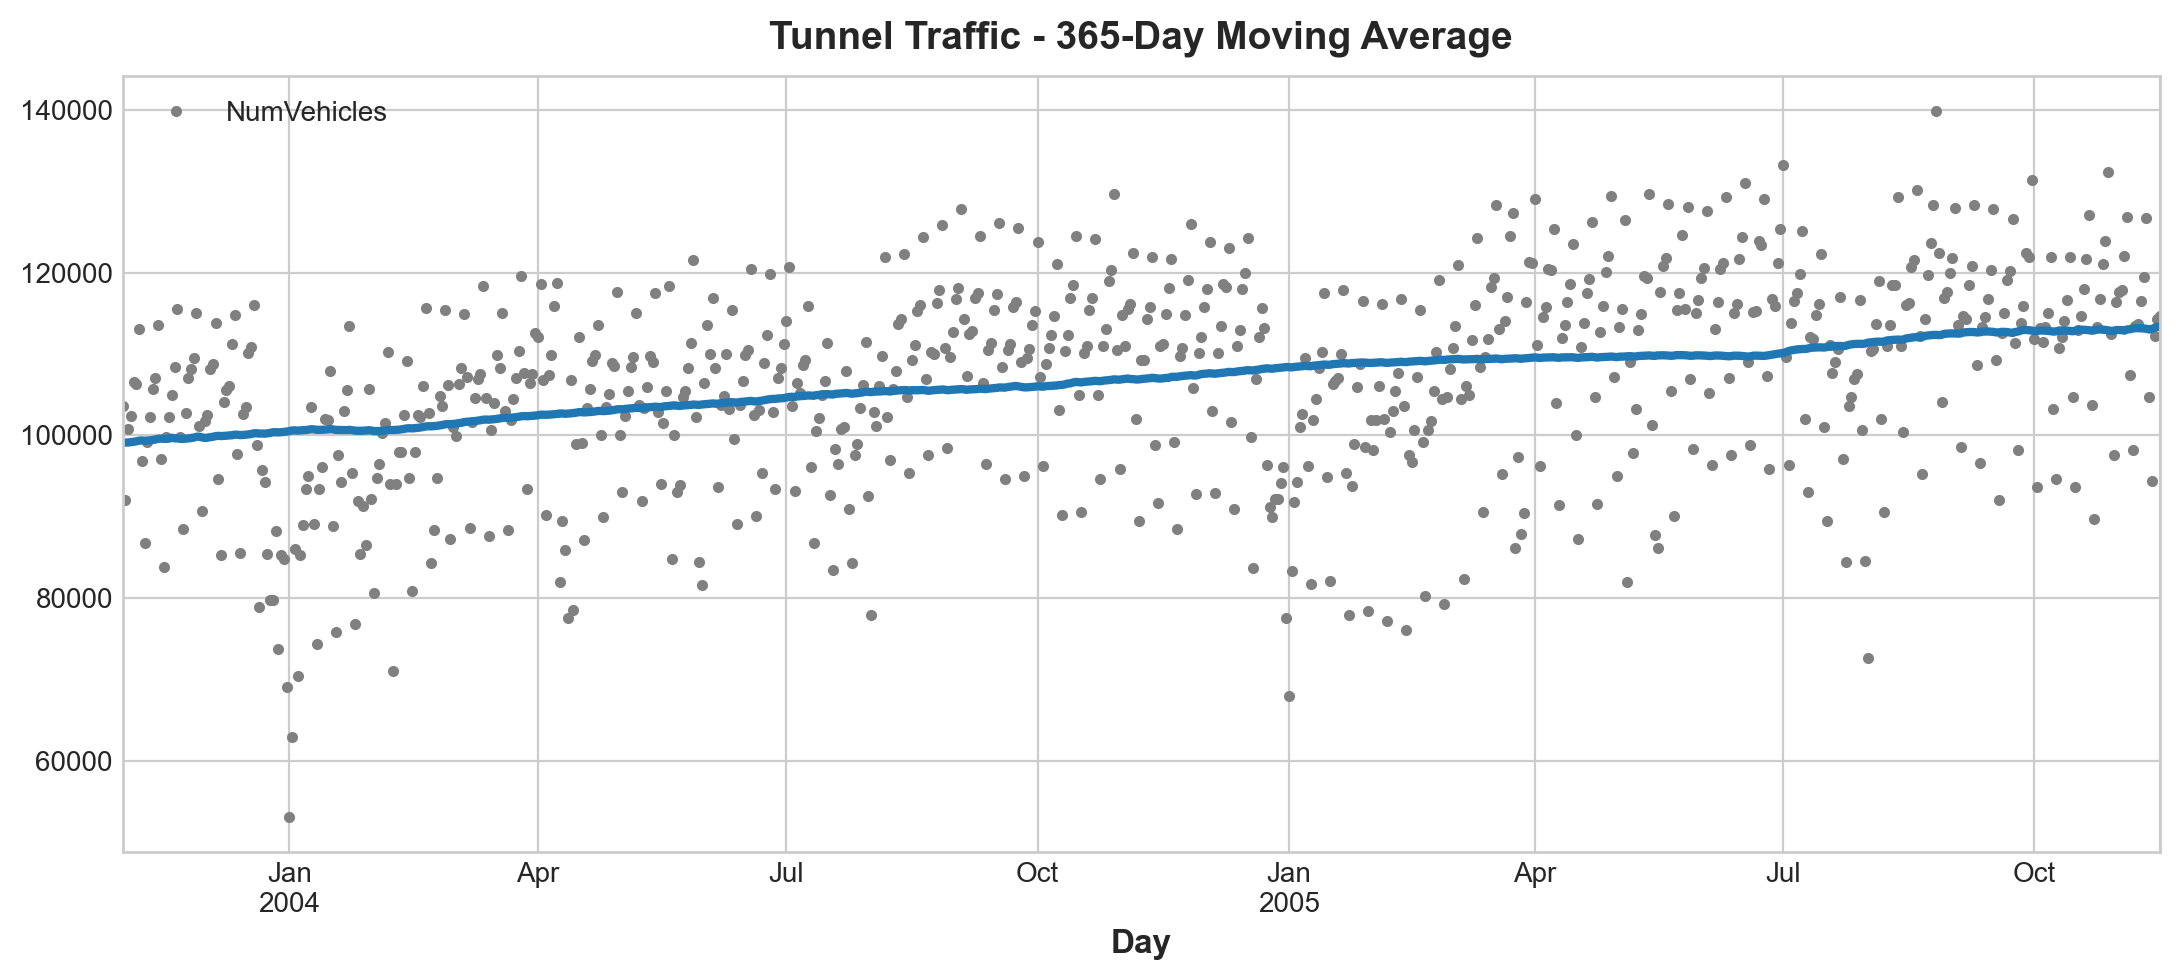

In [4]:
#365일 이동 평균을 계산
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

#앞뒤 182일 포함한 365일 동안의 평균 나타내기

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

- 시간 더미 변수 생성
    - 판다스 (Lesson1)
    - DeterministicProcess from statesmodels library
        - 1: linear (선형)
        - 2 : quadraic (이차)
        - 3 : cubic (삼차)

In [5]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept) 더비 변수 추가
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity(다중 공선성)
)

# `in_sample` : 'index' 인자에서 제공된 날짜에 대한 특성 생성 -> const, trend 변수 생성 
X = dp.in_sample()

X.head()

#const : 절편을 위한 더미 변수
#trend : 날짜에 따라 1씩 증가하는 선형 추세 변수

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [6]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from DeterministicProcess.
# LinearRegression behaves badly with duplicated features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False) #절편 포함X -> const 변수와 중복 방지
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

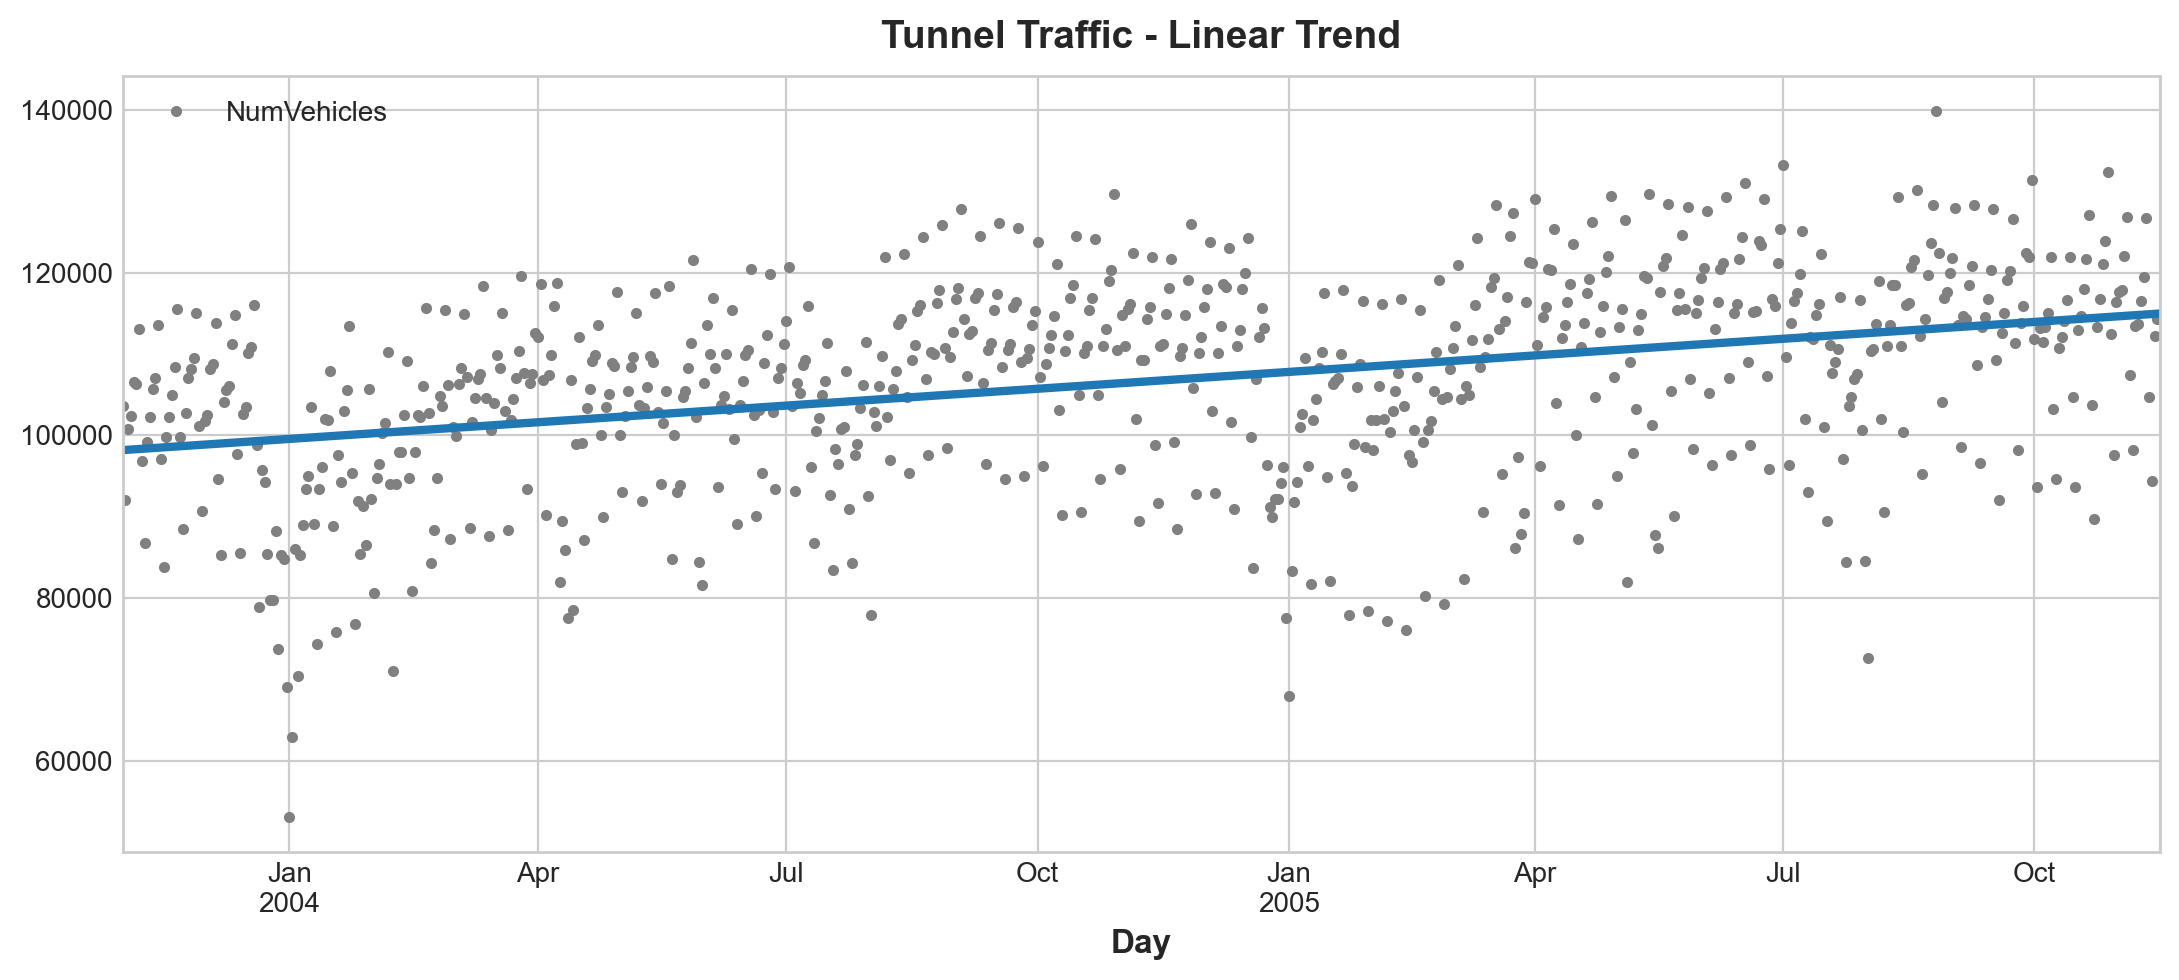

In [7]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

- out of sample : 훈련 데이터의 관측 기간 외의 시간을 예측

In [8]:
#30일 예측
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

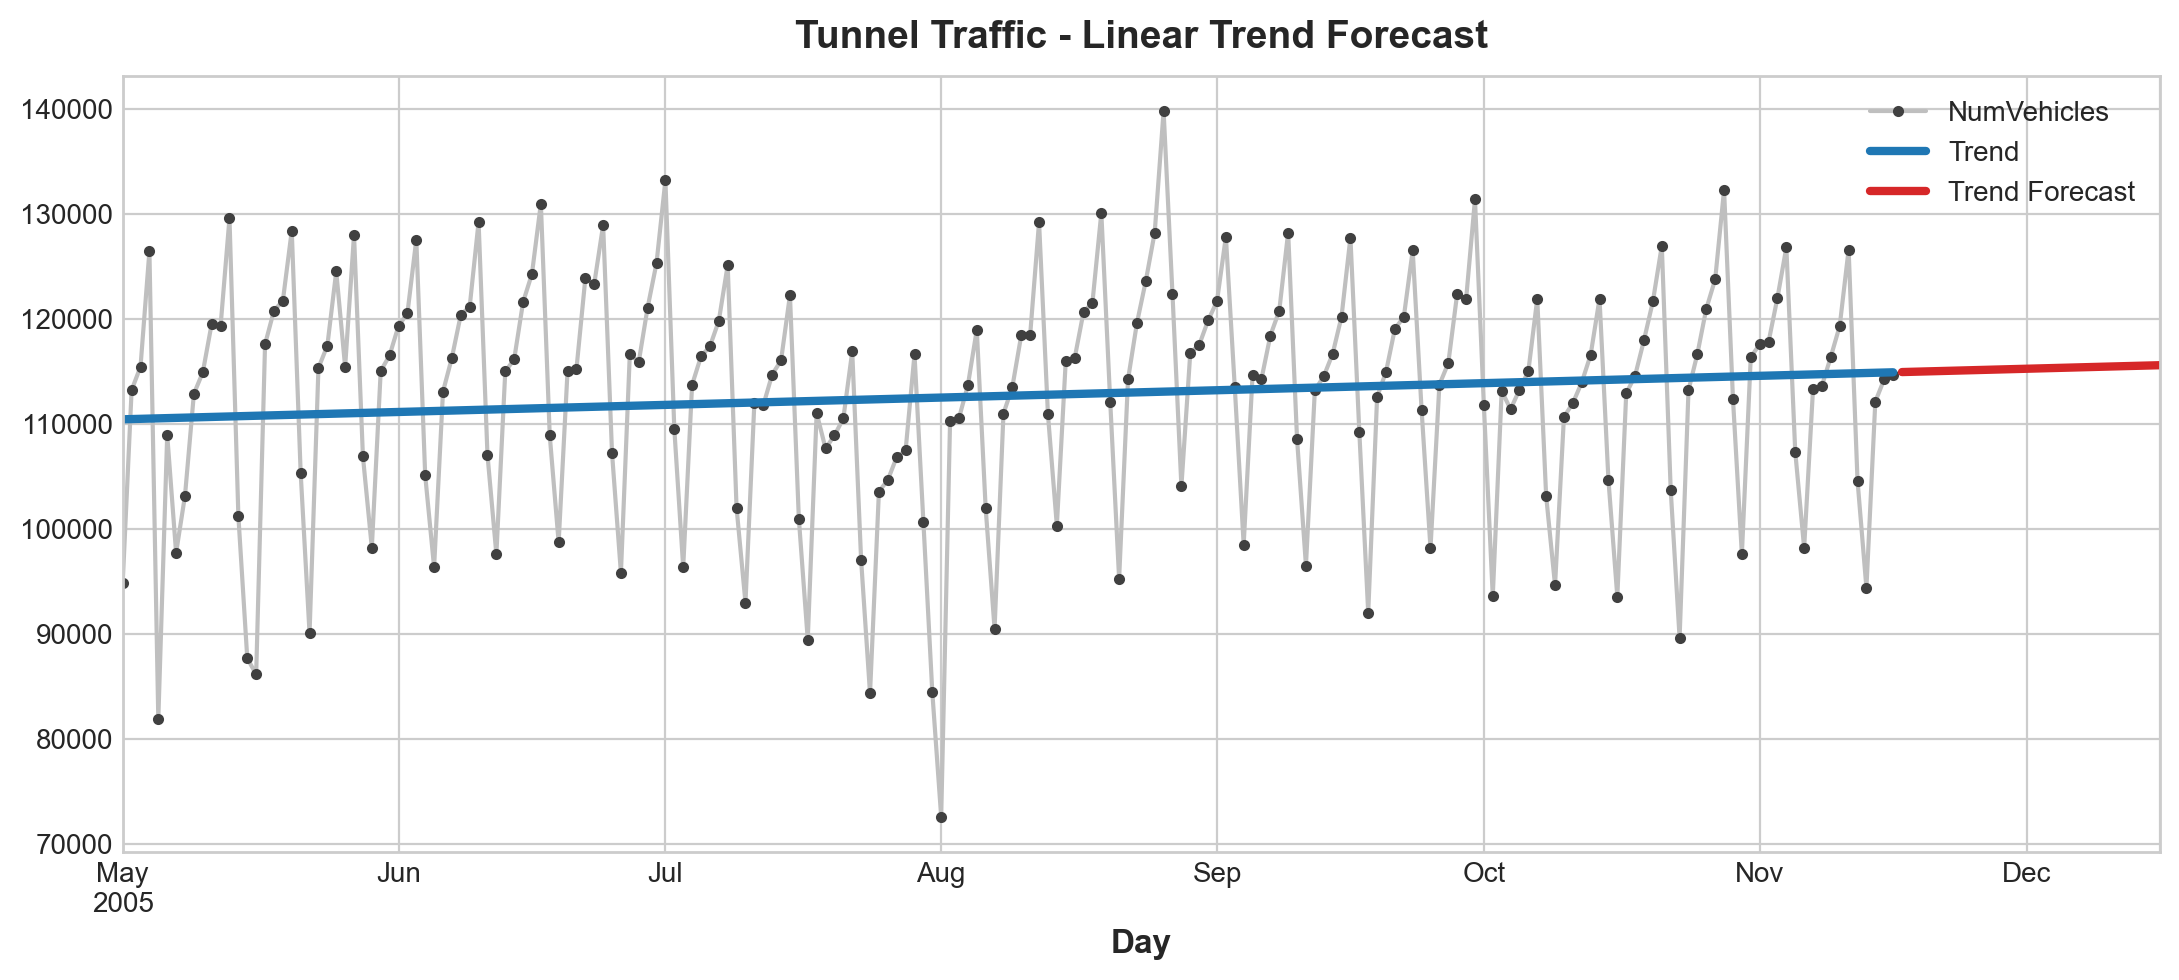

In [9]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()